In [1]:
import sys
sys.path.append('../')

import numpy as np
import cupy as cp
import opticaldevicelib_1d as od_1d
import matplotlib.pyplot as plt
# od_1d.OpticalDevice.init_values(new_dx=1e-9, new_Nx=2**20, gpu_use=True)
od_1d.OpticalDevice.init_values(new_dx=5e-8, new_Nx=2**10, gpu_use=True)
# od_1d.OpticalDevice.init_values(new_dx=5e-9, new_Nx=2**16, gpu_use=True)
# od_1d.OpticalDevice.init_values(new_dx=0.325e-6, new_Nx=2**10, gpu_use=True)
print(f"мера поля X = {od_1d.OpticalDevice.Nx * od_1d.OpticalDevice.dx * 1e6} мкм")

GPU is available!
мера поля X = 51.199999999999996 мкм


Оптическая схема с СПЛ с дефектами

In [ ]:
"""Инициализация точечного источника"""
p = od_1d.PointSource(z=15, x0=0, En=12) 
E_ps1 = np.ones_like(p.E())

"""Параметры СПЛ"""
N_gl = 26
Copy_flag = True
A = 50e-6
R = 6.25e-6
d = 2e-6
mol = "Si"
dens = 2.33

"""Инициализация СПЛ"""
crl_ideal = od_1d.CRL(lam=p.lam, arr_start=E_ps1, z=0, R=R, A=A, d=d, N_lens=N_gl, mol=mol, dens=dens)

crl_m =  od_1d.CRLm(lam=p.lam, arr_start=E_ps1, z=0, R=6.25e-6, A=50e-6, d=2e-6, N_lens=26, mol='Si', dens=2.33,\
                     copy=Copy_flag, sigma=1.2e-6, height=0.1e-6, height_c=-0.35e-6, shift=3.2e-6)

focus = crl_ideal.focus()

print(f"фокусное расстояние = {focus * 1e3 :.3f} мм")

фокусное расстояние = 34.634 мм


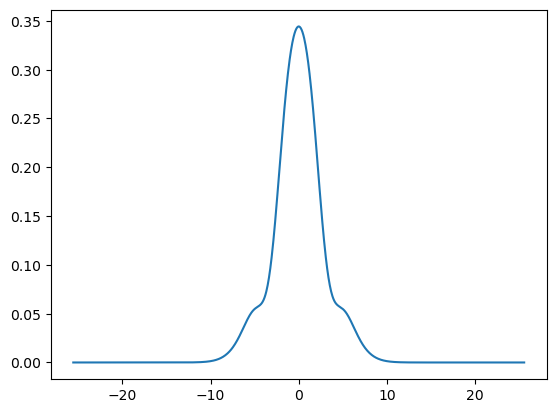

In [3]:
def gauss(x, A, mu, sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

def shape_error(x, A_c, sig_c, A_s, sig_s, mu_s):
    return gauss(x, A_c, 0, sig_c) + gauss(x, A_s, mu_s, sig_s) + gauss(x, A_s, -mu_s, sig_s)    

xxx = p.x.get() * 1e6

# plt.plot(xxx, gauss(xxx, 0.3, 0, 0.3))

A_c = 0.35
A_s = -0.1
sig_c = 3
sig_s = 1.2
mu_s = 3.2

plt.plot(xxx, shape_error(xxx, A_c, sig_c, A_s, sig_s, mu_s))

dx = 2.1428571428571423


(2000, 7)

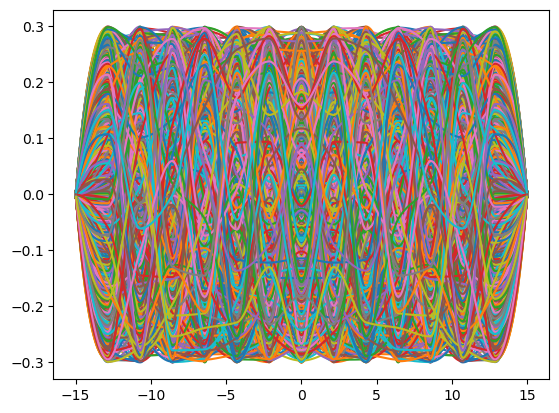

In [4]:
from scipy.interpolate import Akima1DInterpolator, CubicSpline, PchipInterpolator
def spline_error(num_patterns, x, x_edge, n_peaks, seed):
    np.random.seed(seed)
    # n_peaks += 2
    x_peaks = np.linspace(-x_edge, x_edge, n_peaks+2)
    print(f"dx = {x_peaks[1]-x_peaks[0]}")
    xnew = x[abs(x)<x_edge]
    patterns = np.zeros((num_patterns, len(xnew)))
    coefs = np.zeros((num_patterns, n_peaks//2+1))
    for i in range(num_patterns):
        y_peaks = np.random.uniform(-0.3, 0.3, n_peaks//2+1)
        
        # y_peaks = np.random.normal(0, 0.1, n_peaks//2+1)
        # y_peaks[0] = np.random.normal(0.35, 0.01)

    #     E_y_peaks = np.array([ 0.3934644 ,  0.26365796,  0.01615896,  0.00479027, -0.06990927,
    #    -0.11872622, -0.14037278])
        # y_peaks = np.random.normal(E_y_peaks, 0.025, n_peaks//2+1)
        
        coefs[i] = y_peaks
        y_peaks = np.concatenate([y_peaks[:0:-1], y_peaks])
        y_peaks = np.pad(y_peaks, pad_width=1, mode='constant', constant_values=0)
        # spl = Akima1DInterpolator(x_peaks, y_peaks)
        # spl = CubicSpline(x_peaks, y_peaks)
        spl = PchipInterpolator(x_peaks, y_peaks)
        patterns[i] = spl(xnew)

    return patterns, coefs, x_peaks[n_peaks//2+1:n_peaks+1]

x_edge = 15
n_patterns = 2000
n_peaks = 13
patterns, coefs, x_peaks = spline_error(n_patterns, xxx, x_edge, n_peaks, 42)

plt.plot(xxx[abs(xxx)<x_edge], patterns.T)
plt.scatter(x_peaks, coefs[-1], s=50)
coefs.shape

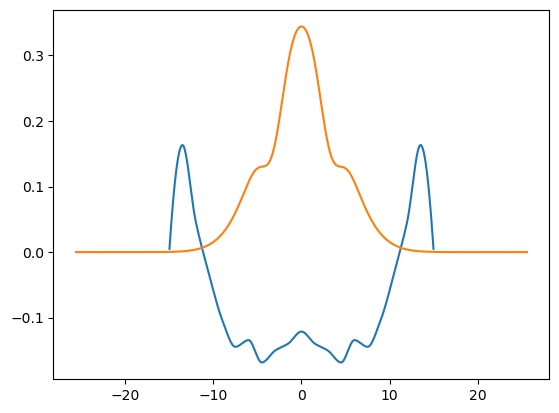

In [33]:
def coefs_to_spline(x, x_edge, coefs):
    n_peaks = len(coefs) * 2 - 1
    x_peaks = np.linspace(-x_edge, x_edge, n_peaks+2)
    xnew = x[abs(x)<x_edge]
    y_peaks = coefs
    y_peaks = np.concatenate([y_peaks[:0:-1], y_peaks])
    y_peaks = np.pad(y_peaks, pad_width=1, mode='constant', constant_values=0)
    # spl = Akima1DInterpolator(x_peaks, y_peaks)
    # spl = CubicSpline(x_peaks, y_peaks)
    spl = PchipInterpolator(x_peaks, y_peaks)
    return spl(xnew)



# coefs_experiment = np.array([-0.37580994, -0.60104007, -0.83018035, -0.91310686]) + 0.9
# coefs_experiment = np.array([0.03037248, -0.30044696, -0.37744778, -0.4424736])
coefs_experiment = coefs[3]

coefs_experiment1 = np.array([-0.12123197, -0.13951704, -0.15029344, -0.16840576, -0.13425624,
       -0.14451087, -0.10306165, -0.03294156,  0.04710029,  0.16337004])


# coefs_experiment2 = np.array([0.3974196 ,  0.23195356, -0.01833989, -0.00813345, -0.0673206 ,
#        -0.100799  , -0.07989032])

# coefs_experiment3 = np.array([ 0.3934644 ,  0.26365796,  0.01615896,  0.00479027, -0.06990927,
#        -0.11872622, -0.14037278])

# coefs_experiment4 = np.array([ 0.38027665,  0.25669044,  0.03372955,  0.01181077, -0.06278558,
#        -0.10846245, -0.11806641])

# coefs_experiment -= np.mean(coefs_experiment)

# spline_test = coefs_to_spline(xxx, 15, 7, [-0.01868962, -0.16304732,  0.12059945,  0.07774074]) # пример
# spline_test = coefs_to_spline(xxx, 15, 7, [0.04097161, -0.05543634, -0.19499692, -0.37375382]) 
spline_test = coefs_to_spline(xxx, x_edge, coefs_experiment1)

# spline_test3 = coefs_to_spline(xxx, x_edge, coefs_experiment3)

# spline_test4 = coefs_to_spline(xxx, x_edge, coefs_experiment4)


%matplotlib inline

# plt.scatter(x_peaks, coefs_experiment2)
# plt.scatter(x_peaks, coefs_experiment3)
plt.plot(xxx[abs(xxx)<x_edge], spline_test)
# plt.plot(xxx[abs(xxx)<x_edge], spline_test3)
# plt.plot(xxx[abs(xxx)<x_edge], spline_test4)
plt.plot(xxx, (crl_m.T()-crl_ideal.T()).get()*1e6)

 dz = 15.36620375251125 mm 
 dx = 0.0 μm 
 fwhm = 0.16474342637876943 μm 
 I_max = 56.71687023406993 rel. un. 
 div_ang = nan


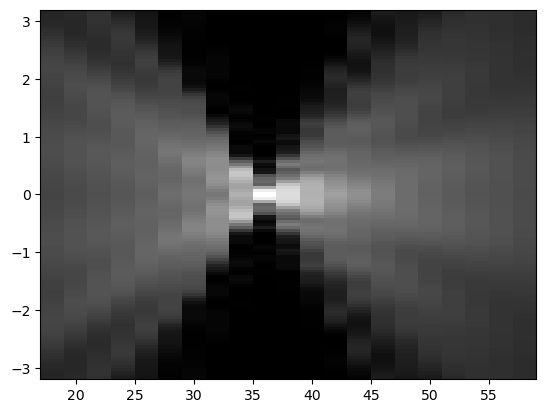

In [34]:
"""Точечный источник"""
z_arr = np.arange(16, 57, 2) * 1e-3
# z_arr = np.array([focus])

T_ideal = crl_ideal.T() * 1e6

t_loop = cp.array(T_ideal).copy()
t_loop[abs(xxx)<x_edge] = t_loop[abs(xxx)<x_edge] + cp.array(spline_test)


I_distr_max, I_max, dz_max_1, dx_max, fwhm, focus_images, z_arr, div_ang, x_cutted\
     = crl_m.focus_params(z_arr, T_arr=t_loop*1e-6, n_cut=64, focus=34e-3)

print(f" dz = {(5e-2+dz_max_1*1e-3-crl_m.focus())*1e3} mm \n dx = {dx_max} μm \n fwhm = {fwhm*1e6} μm \n I_max = {I_max} rel. un. \n div_ang = {div_ang}")
I_sum_dot = abs(focus_images)**2
I_sum_dot = I_sum_dot.get()

plt.pcolormesh(z_arr*1e3+2, x_cutted*1e6, np.log1p(I_sum_dot.T), cmap="Greys_r")
# plt.ylim(-8, 10)
# plt.xticks(np.arange((z_arr*1e3+2)[0], (z_arr*1e3+2)[-1]+4, step=4))
# plt.yticks(np.arange(-8, 8+2, step=2));

In [35]:
"Протяженный источник"
crl_m.set_z(z=focus)
I_arr_test = crl_m.I()
z_arr = np.arange(16, 57, 2) * 1e-3

N_source_x = 21
size_source_x = cp.linspace(-2e-4, 2e-4, N_source_x)


def gauss_1d(x, sig):
    return np.exp(-0.5*(x/sig)**2)

gauss_test = cp.zeros(shape=(N_source_x))

sig = 1.17e-4 / 2.355

# sh1, sh2 = I_arr_test.shape
sh_z = len(z_arr)
I_sum = cp.zeros(shape=I_sum_dot.shape)
# I_sum_ideal = cp.zeros(shape=I_sum_dot.shape)

# phase_sum = cp.zeros(shape=(sh_z, int(20e-6/od_2d.OpticalDevice.dy)*2, int(20e-6/od_2d.OpticalDevice.dx)*2))
# phase_sum_ideal = cp.zeros(shape=(sh_z, int(20e-6/od_2d.OpticalDevice.dy)*2, int(20e-6/od_2d.OpticalDevice.dx)*2))

# t_loop = crl_global.T()


patterns = cp.array(patterns)
# t_loop = cp.array(T_ideal)

# N_frame = 8000

i_start = 0
i_end = 1
I_data = cp.empty(shape=(i_end-i_start, len(z_arr), 128))

from tqdm import tqdm

for i in tqdm(range(i_start, i_end)):
    # print(f"---FRAME № {i}---")
    t_loop = cp.array(T_ideal).copy()
    t_loop[abs(xxx)<x_edge] = t_loop[abs(xxx)<x_edge] + cp.array(spline_test)
    # t_loop[abs(xxx)<x_edge] = t_loop[abs(xxx)<x_edge] + patterns[i]
    t_loop *= 1e-6
    I_sum = cp.zeros(shape=I_sum_dot.shape)
    for j, x0 in enumerate(size_source_x):
        p_loop = od_1d.PointSource(En=12, z=15, x0=x0)
        E_p_loop = p_loop.E()

        crl_loop = od_1d.CRLm(lam=p_loop.lam, arr_start=E_p_loop, z=0, R=6.25e-6, A=50e-6, d=2e-6, N_lens=26, mol='Si', dens=2.33,\
                        copy=Copy_flag, sigma=1.2e-6, height=0.1e-6, height_c=-0.35e-6, shift=3.2e-6)

        gauss_test[j] = gauss_1d(x0, sig)
            
        I_distr_max, I_max, dz_max_1, dx_max, fwhm, focus_images, z_arr, div_ang, x_cutted\
            = crl_loop.focus_params(z_arr, T_arr=t_loop, n_cut=64, focus=34e-3)
        
        I_sum += abs(focus_images)**2 * gauss_test[j] / N_source_x
    I_data[i-i_start] = I_sum

100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


In [ ]:
# cp.save("I_spline_err_data", I_data)
# np.save("coefs_spline_err_data", coefs)

In [ ]:
# cp.save("I_pchip_3k_err_data", I_data)
# np.save("coefs_pchip_3k_err_data", coefs)

In [ ]:
# cp.save("I_zero_fix_1k_err_data", I_data)
# np.save("coefs_zero_fix_1k_err_data", coefs)

In [ ]:
# cp.save("I_fix_1_1k_err_data", I_data)
# np.save("coefs_fix_1_1k_err_data", coefs)

In [ ]:
# cp.save("I_fix_2_2k_err_data", I_data)
# np.save("coefs_fix_2_2k_err_data", coefs)

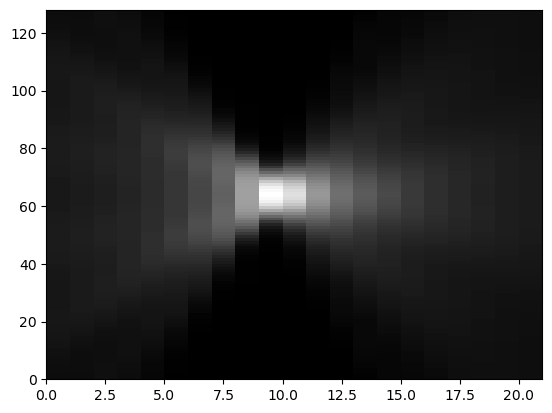

In [36]:
from scipy.ndimage import gaussian_filter1d

I_data_filtered = gaussian_filter1d(I_data[0].get(), 4)

plt.pcolormesh(I_data_filtered.T, cmap="Greys_r")

In [ ]:
21*320

In [ ]:
plt.plot(size_source_x.get()*1e6, gauss_test.get())

In [ ]:
320*21

In [ ]:
plt.pcolormesh(z_arr*1e3, x_cutted*1e6, I_sum.T, cmap="CMRmap")
# plt.ylim(-10, 10)
plt.xticks(np.arange((z_arr*1e3)[0], (z_arr*1e3)[-1]+4, step=4))
# plt.yticks(np.arange(-8, 8+2, step=2));

In [ ]:
plt.plot(I_sum[9])

In [ ]:
from scipy.interpolate import interp1d

def interpolate_image(image, target_width):
  """
  Интерполирует изображение с ширины 1024 пикселей до target_width пикселей.

  Аргументы:
    image: numpy массив с формой (21, 1024), представляющий изображение.
    target_width: Целевая ширина изображения (в данном случае 256).

  Возвращает:
    numpy массив с формой (21, target_width), представляющий интерполированное изображение.
  """

  # Создаем массив x-координат для исходного изображения
  x = np.linspace(0, 1, image.shape[1])  # От 0 до 1, 1024 точки

  # Создаем массив x-координат для интерполированного изображения
  x_new = np.linspace(0, 1, target_width)  # От 0 до 1, target_width точки

  # Инициализируем массив для интерполированного изображения
  interpolated_image = np.zeros((image.shape[0], target_width))

  # Интерполируем каждую строку изображения
  for i in range(image.shape[0]):
    # Создаем функцию интерполяции для текущей строки
    f = interp1d(x, image[i, :], kind='linear')  # Линейная интерполяция

    # Интерполируем строку
    interpolated_image[i, :] = f(x_new)

  return interpolated_image

In [ ]:
plt.pcolormesh(interpolate_image(I_sum, 1024).T, cmap="CMRmap")
# plt.ylim(-10, 10)
# plt.xticks(np.arange((z_arr*1e3)[0], (z_arr*1e3)[-1]+4, step=4))
# plt.yticks(np.arange(-8, 8+2, step=2));